# Indonesian student's potential to go to college

The following notebook explores indonesian high school student data related to the decision to go to college.
<br>
<br>
We used the [Go To College Dataset](https://www.kaggle.com/datasets/saddamazyazy/go-to-college-dataset) due to its high usability and high number of upvotes. This data is made based on high school condition in Indonesia and contains 11 columns. Here's some explanation for each column, provided by the dataset's creator:

- `type_school`: the type of high school (student age 15-18) that the student attends. There are two types of high school here: vocational high school and academic high school. The basic difference between these two is theory versus practice. An academic school generally teaches theoretical knowledge and broad-based research skills, while a vocational school teaches hands-on, applied skills such as carpentry, auto mechanics and hairdressing. Students choose vocational high school usually because they want to quickly get job
- `school_accreditation`: the quality of school. A is the best, followed by B and C
- `gender`: student gender
- `interest`: student interest to go to college
- `residence`: the type of residence (urban or rural)
- `parent_age`: parent age
- `parent_salary`: parent salary per month in IDR/Indonesian Rupiah
- `house_area`: parent house area in meter square (m$^2$)
- `average_grades`: the average of high school grades in scale of 0-100
- `parent_was_in_college`: parent's attendance to college
- `will_go_to_college`: did the student actually go to college or not

Let's import the dataset and give a quick look to the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import time

df = pd.read_csv("./data.csv")
df.head()

ModuleNotFoundError: No module named 'pandas'

Modifichiamo il nome della colonna `will_go_to_college` in `in_college` per restare coerenti con la descrizione dell'attributo (lo studente è andato al college, non è che ci andrà)

In [94]:
df = df.rename(columns={"will_go_to_college": "in_college"})
df.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


It can be noticed that some variables need to be discretized so that they can be supported by `pgmpy`. To do so, we have to preprocess the data.

## 1. Preprocessing

The variables that has to be discretized are: `parent_salary`, `parent_age`, `house_area` and `average_grades`. For each one, we print out the minimum and maximum value to obtain a better distributions of the bins. Finally, we convert the obtained value to `str`.

Non abbiamo trovato papers sull'argomento ma abbiamo discretizzato secondo le informazioni fornite da diversi siti statistici. In particolare ciò che è scritto [qui](https://tradingeconomics.com/indonesia/minimum-wages)

In [95]:
# parent_salary
print('Min:', np.min(df['parent_salary']))
print('Max:', np.max(df['parent_salary']))

Min: 1000000
Max: 10000000


In [96]:
df['parent_salary'] = pd.cut(x=df['parent_salary'],
                             bins=[np.min(df['parent_salary']),5000000,8000000,np.max(df['parent_salary'])],
                             labels=["Low", "Medium", "High"],
                             include_lowest=True)

df['parent_salary'] = df['parent_salary'].astype(str)

In [97]:
# parent_age
print('Min:', np.min(df['parent_age']))
print('Max:', np.max(df['parent_age']))

Min: 40
Max: 65


In [98]:
df['parent_age'] = pd.cut(x=df['parent_age'],
                          bins=[np.min(df['parent_age']),45,50,55,60,np.max(df['parent_age'])],
                          labels=["40-45","45-50", "50-55", "55-60", "60-65"],
                          include_lowest=True)

df['parent_age'] = df['parent_age'].astype(str)

In [99]:
# house_area
print('Min:', np.min(df['house_area']))
print('Max:', np.max(df['house_area']))

Min: 20.0
Max: 120.0


In [100]:
df['house_area'] = pd.cut(x=df['house_area'],
                          bins=[np.min(df['house_area']),60,90,np.max(df['house_area'])],
                          labels=["Small","Medium","Big"],
                          include_lowest=True)

df['house_area'] = df['house_area'].astype(str)

In [101]:
# average_grades
print('Min:', np.min(df['average_grades']))
print('Max:', np.max(df['average_grades']))

Min: 75.0
Max: 98.0


In [102]:
df['average_grades'] = pd.cut(x=df['average_grades'],
                              bins=[np.min(df['average_grades']),85,95,np.max(df['average_grades'])],
                              labels=["75 - 85","85 - 95","95+"],
                              include_lowest=True)

df['average_grades'] = df['average_grades'].astype(str)

Osserviamo i risultati della discretizzazione.

In [103]:
df.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,A,Male,Less Interested,Urban,55-60,Medium,Medium,75 - 85,False,True
1,Academic,A,Male,Less Interested,Urban,55-60,Low,Medium,85 - 95,False,True
2,Academic,B,Female,Very Interested,Urban,45-50,Medium,Medium,85 - 95,False,True
3,Vocational,B,Male,Very Interested,Rural,45-50,Medium,Medium,75 - 85,True,True
4,Academic,A,Female,Very Interested,Urban,55-60,Medium,Medium,85 - 95,False,False


/var/folders/yy/7vjk399x4ls139wgb41m3j7w0000gn/T/ipykernel_1151/3466518570.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


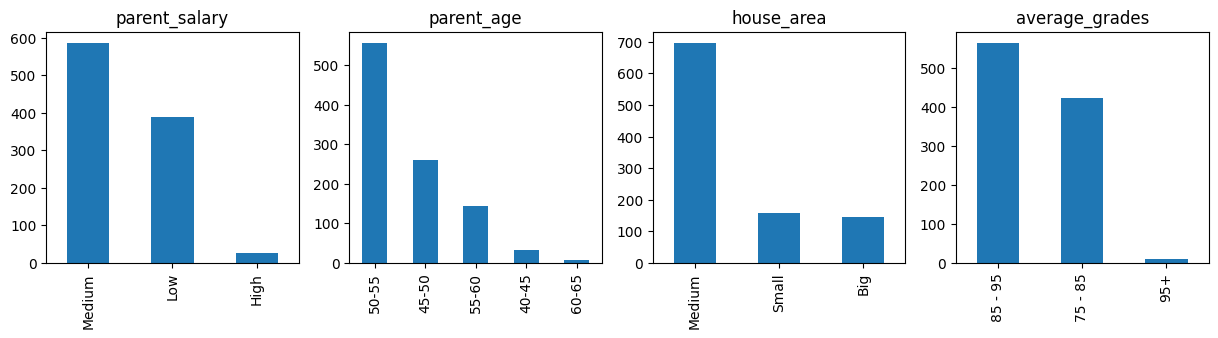

In [104]:
discretized_features = ['parent_salary', 'parent_age', 'house_area', 'average_grades']

fig, ax = plt.subplots(1, len(discretized_features))
for i, feature in enumerate(df[discretized_features]):
    df[feature].value_counts().plot(kind="bar", ax=ax[i], figsize=(15,3)).set_title(feature)
fig.show()

## 2. Data Exploration

Esploriamo i dati in modo da comprendere le relazioni tra gli attributi e fare delle inferenze.

Le prime relazioni che abbiamo esplorato sono quelle riguardanti gli attributi che, secondo noi, potrebbero direttamente influenzare la scelta dello studente di frequentare il college. Tra questi l'interesse, il tipo di liceo frequentato, la prestigiosità del liceo, il genere e la frequentazione del college da parte del genitore.

#### 1. Interest

Intuitivamente verrebbe da pensare che l'interesse di uno studente nell'andare al college sia strettamente correlato al frequentare effettivamente il college. Analizziamo la relazione tra queste due variabili:

<AxesSubplot: xlabel='interest', ylabel='count'>

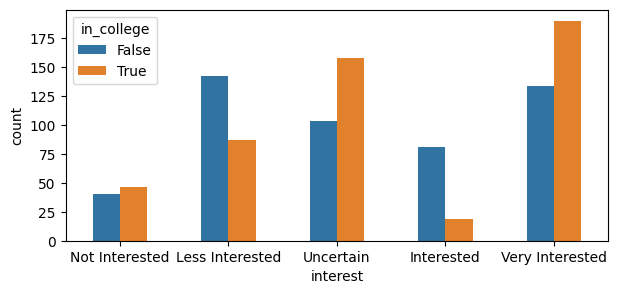

In [105]:
plt.figure(figsize=(7,3))
sns.countplot(data=df,
              x='interest',
              hue='in_college', 
              order=['Not Interested','Less Interested','Uncertain','Interested','Very Interested'],
              width=0.5
             )

Actually, the graph shows that interest doesn't linearly correlates with college admission. But why? Well, there are students who are (very) interested to go to college that don't get accepted and there are students who are not interested to go to college but still go to college. In conclusion, we can state that `interest` does not necessarily imply `in_college`.

#### 2. Type of school

Come spiegato dal creatore del dataset, in Indonesia ci sono due tipi di liceo. Tipicamente, gli studenti che optano per un liceo di tipo Vocational sono coloro maggiormente interessati ad ottenere conoscenze pratiche da spendere subito nel mondo del lavoro. Dunque si potrebbe desumere che il tipo di scuola sia correlato con la scelta di andare al college.

<AxesSubplot: xlabel='type_school', ylabel='count'>

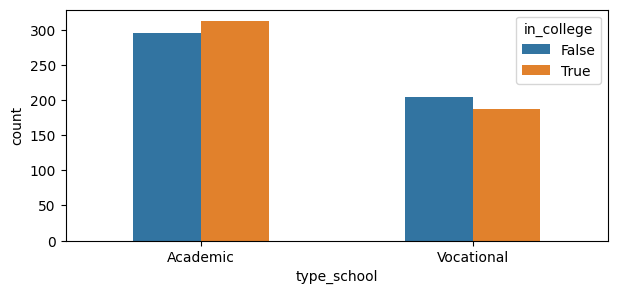

In [106]:
plt.figure(figsize=(7,3))
sns.countplot(data=df,
              x='type_school',
              hue='in_college',
              width=0.5
             )

Students of academic high school are a little more likely to go to college.

#### 3. School accreditation

L'ammissione al college potrebbe essere influenzata dalla prestigiosità del liceo.

<AxesSubplot: xlabel='school_accreditation', ylabel='count'>

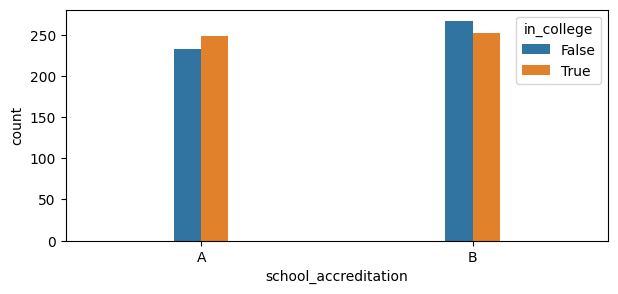

In [107]:
plt.figure(figsize=(7,3))
sns.countplot(data=df,
              x='school_accreditation',
              hue='in_college',
              width=0.2
             )

The countplot shows that students of good accredited high school are a little more likely to go to college.

#### 4. Gender

Vediamo se il genere influisce sull'andare al college (no intention for gender discrimination)

<AxesSubplot: xlabel='gender', ylabel='count'>

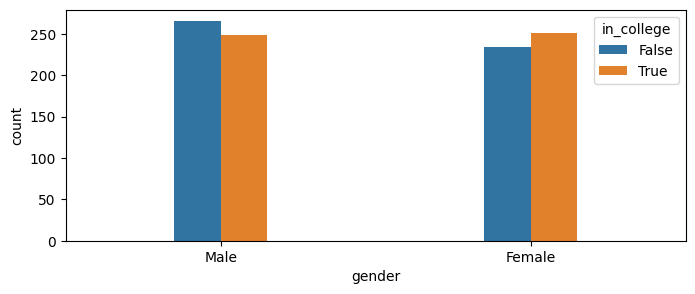

In [108]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,
              x='gender',
              hue='in_college',
              width=0.3
             )

Female students are a little more likely to go to college.

#### 5. Parent was in college

Se il genitore è andato al college, il figlio sarà più propenso ad andare al college?

<AxesSubplot: xlabel='parent_was_in_college', ylabel='count'>

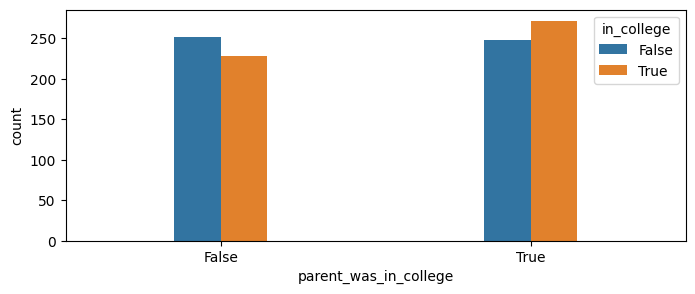

In [109]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,
              x='parent_was_in_college',
              hue='in_college',
              width=0.3
             )

The graph shows... bla bla bla... vedi tu. If the parent was in college, the student will more likely go to college.

#### 6. Average grades

<AxesSubplot: xlabel='average_grades', ylabel='count'>

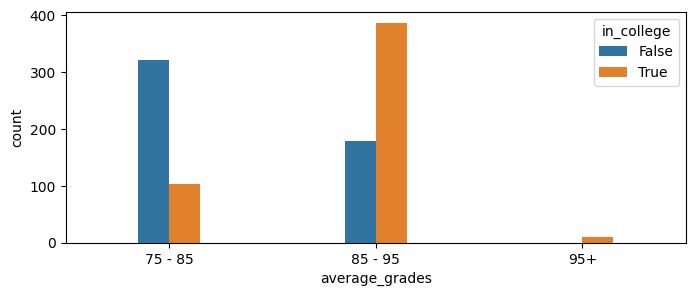

In [110]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,
              x='average_grades',
              hue='in_college',
              width=0.3
             )

Gli studenti con una media di voti medio-alta sono più portati verso la scelta del college.

#### 7. Parent salary

Dato che il college è costoso, un'ulteriore implicazione potrebbe essere quella che coinvolge il salario percepito dal genitore.

<AxesSubplot: xlabel='parent_salary', ylabel='count'>

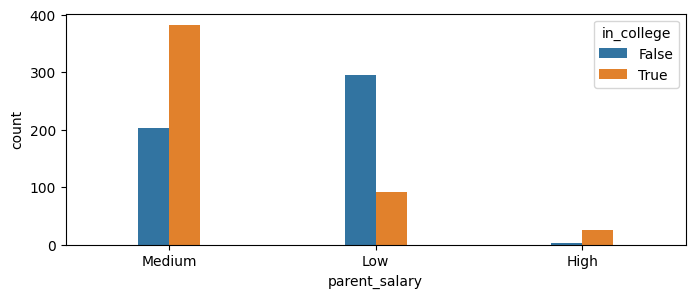

In [111]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,
              x='parent_salary',
              hue='in_college',
              width=0.3
             )

*Adesso esaminiamo le relazioni che sussistono tra gli attributi che non influenzano direttamente la scelta di frequentare il college.*

**1. Parent age -> Salary**

In [ ]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,
              x='parent_age',
              hue='parent_salary',
              width=0.3
             )

**2. Parent was in college -> Parent salary**

In [ ]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,
              x='parent_was_in_college',
              hue='parent_salary',
              width=0.3
             )

**3. Parent salary -> House area**

In [ ]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,
              x='parent_salary',
              hue='house_area',
              width=0.3
             )

**4. Parent salary -> Residence**

In [ ]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,
              x='parent_salary',
              hue='residence',
              width=0.3
             )

**5. Residence -> Type of school**

In [ ]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,
              x='residence',
              hue='type_of_school',
              width=0.3
             )

**6. Average grades -> Interest**

In [ ]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,
              x='average_grades',
              hue='interest',
              width=0.3
             )

**Teoria**

//PACCO 3

- Compact conditional distributions (Vedi se mettere riferimento) -> solo discorsiva, no codice

## Bayesian Network

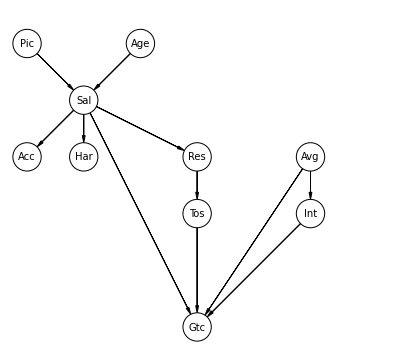

In [21]:
import daft #(punk)
import matplotlib.pyplot as plt
from daft import PGM

pgm = PGM(shape=[7, 6])

pgm.add_node(daft.Node('Pic', r"Pic", 1, 6))
pgm.add_node(daft.Node('Age', r"Age", 3, 6))

pgm.add_node(daft.Node('Sal', r"Sal", 2, 5))

pgm.add_node(daft.Node('Acc', r"Acc", 1, 4))
pgm.add_node(daft.Node('Har', r"Har", 2, 4))
pgm.add_node(daft.Node('Res', r"Res", 4, 4))
pgm.add_node(daft.Node('Avg', r"Avg", 6, 4))

pgm.add_node(daft.Node('Tos', r"Tos", 4, 3))
pgm.add_node(daft.Node('Int', r"Int", 6, 3))

pgm.add_node(daft.Node('Gtc', r"Gtc", 4, 1))


pgm.add_edge('Pic', 'Sal')
pgm.add_edge('Age', 'Sal')
pgm.add_edge('Sal', 'Acc')
pgm.add_edge('Sal', 'Har')
pgm.add_edge('Sal', 'Gtc')
pgm.add_edge('Sal', 'Res')
pgm.add_edge('Res', 'Tos')
pgm.add_edge('Avg', 'Gtc')
pgm.add_edge('Avg', 'Int')
pgm.add_edge('Tos', 'Gtc')
pgm.add_edge('Int', 'Gtc')


pgm.render()
plt.show()

### Network implementation

In [22]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork([('parent_was_in_college','parent_salary'),('parent_age','parent_salary'),
                         ('parent_salary','school_accreditation'),('parent_salary','house_area'),
                         ('parent_salary','will_go_to_college'),('parent_salary','residence'),
                         ('residence', 'type_school'), ('average_grades', 'will_go_to_college'), 
                         ('average_grades','interest'),('type_school', 'will_go_to_college'), 
                         ('interest', 'will_go_to_college')])



**Teoria da inserire** 

1. Basic independences (eventuali strutture a V)

//PACCO 2

Basic Independencies in the will-I-go-to-college network -> mostriamo le indipendenze<br>
Flow of Probabilistic Influence<br>
- direct cause
- direct effect
- causal trail
- evidential trail
    - Active Trail
    - Direct Separation (d-separation)
    
Markov Blanket (prendi un nodo e falla vedere)

//PACCO 3
- Irrelevant variables

## Parameter Estimation


teoria dell'estimator MLE-> https://towardsdatascience.com/maximum-likelihood-vs-bayesian-estimation-dd2eb4dfda8a

CPD = conditional probability distribution
CPT = conditional probability table

DA FARE!!!

->student_model.check_model()

In [105]:
from pgmpy.estimators import MaximumLikelihoodEstimator

model.cpds = []
model.fit(data=df, estimator=MaximumLikelihoodEstimator)

print("Check model: ", model.check_model())

# let's show cpt's
for cpd in model.get_cpds():
    print(cpd.variable)
    print(cpd)

Check model:  True
parent_was_in_college
+------------------------------+------+
| parent_was_in_college(False) | 0.48 |
+------------------------------+------+
| parent_was_in_college(True)  | 0.52 |
+------------------------------+------+
parent_salary
+-----------------------+------------------------------+-----+-----------------------------+
| parent_age            | parent_age(40-45)            | ... | parent_age(60-65)           |
+-----------------------+------------------------------+-----+-----------------------------+
| parent_was_in_college | parent_was_in_college(False) | ... | parent_was_in_college(True) |
+-----------------------+------------------------------+-----+-----------------------------+
| parent_salary(High)   | 0.6                          | ... | 0.0                         |
+-----------------------+------------------------------+-----+-----------------------------+
| parent_salary(Low)    | 0.0                          | ... | 0.0                         |
+

## Reasoning (query)

- Causal: will George get a strong reference letter? (prediction)
- Evidential: is George a good potential recruit? (explanation)
- Intercausal: why did George score low/high? (explaining away)

### Exact Inference

//PACCO 3

- Exact Inference (metti formula e come si calcola spiegazione)
  	- Inference by enumeration (vedi se pgmpy ce l'ha)
  	- Inference by variable elimination

#### Causal
Cerchiamo di predirre la classe target, con una o più evidenze

In [24]:
from pgmpy.inference import VariableElimination

vel_inference = VariableElimination(model)

q_cau1 = vel_inference.query(['will_go_to_college'], show_progress=False)

print(q_cau1)

+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.4583 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.5417 |
+---------------------------+---------------------------+


In [107]:
print('P(Letter|Intelligence=normal,Difficulty=easy)')
print('P(will_go_to_college | interest = Not Interested)')
q_cau2 = vel_inference.query(['will_go_to_college'],{'interest':'Not Interested'}, show_progress=False)

print(q_cau2)

P(Letter|Intelligence=normal,Difficulty=easy)
P(will_go_to_college | interest = Not Interested)
+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.3400 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.6600 |
+---------------------------+---------------------------+


In [26]:
q_cau3 = vel_inference.query(['will_go_to_college'],{'interest':'Less Interested'}, show_progress=False)

print(q_cau3)

+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.5392 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.4608 |
+---------------------------+---------------------------+


In [27]:
q_cau4 = vel_inference.query(['will_go_to_college'],{'interest':'Not Interested', 'parent_salary':'Low'}, show_progress=False)

print(q_cau4)

+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.9271 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.0729 |
+---------------------------+---------------------------+


#### Evidential
Possiamo cercare la probabilità di qualsiasi attributo data una a o più evidenze.

In [28]:
q_ev1 = vel_inference.query(['average_grades'],{'will_go_to_college':1}, show_progress=False)

print(q_ev1)

+-------------------------+-----------------------+
| average_grades          |   phi(average_grades) |
+=========================+=======================+
| average_grades(75 - 85) |                0.2536 |
+-------------------------+-----------------------+
| average_grades(85 - 95) |                0.7312 |
+-------------------------+-----------------------+
| average_grades(95+)     |                0.0152 |
+-------------------------+-----------------------+


In [29]:
q_ev2 = vel_inference.query(['average_grades'],{'will_go_to_college':0}, show_progress=False)

print(q_ev2)

+-------------------------+-----------------------+
| average_grades          |   phi(average_grades) |
+=========================+=======================+
| average_grades(75 - 85) |                0.6253 |
+-------------------------+-----------------------+
| average_grades(85 - 95) |                0.3708 |
+-------------------------+-----------------------+
| average_grades(95+)     |                0.0039 |
+-------------------------+-----------------------+


Quality of education A B
http://www.gbgindonesia.com/en/education/article/2011/ensuring_quality_over_quantity_in_higher_education.php

In [30]:
q_ev3 = vel_inference.query(['parent_salary'],{'house_area':'Medium', 'school_accreditation':'B'}, show_progress=False)

print(q_ev3)

+-----------------------+----------------------+
| parent_salary         |   phi(parent_salary) |
+=======================+======================+
| parent_salary(High)   |               0.1445 |
+-----------------------+----------------------+
| parent_salary(Low)    |               0.0552 |
+-----------------------+----------------------+
| parent_salary(Medium) |               0.8003 |
+-----------------------+----------------------+


In [31]:
q_ev3 = vel_inference.query(['parent_salary'],{'house_area':'Big', 'school_accreditation':'B'}, show_progress=False)

print(q_ev3)

+-----------------------+----------------------+
| parent_salary         |   phi(parent_salary) |
+=======================+======================+
| parent_salary(High)   |               0.1523 |
+-----------------------+----------------------+
| parent_salary(Low)    |               0.0393 |
+-----------------------+----------------------+
| parent_salary(Medium) |               0.8084 |
+-----------------------+----------------------+


In [32]:
q_ev3 = vel_inference.query(['parent_salary'],{'house_area':'Small', 'school_accreditation':'B'}, show_progress=False)

print(q_ev3)

+-----------------------+----------------------+
| parent_salary         |   phi(parent_salary) |
+=======================+======================+
| parent_salary(High)   |               0.0630 |
+-----------------------+----------------------+
| parent_salary(Low)    |               0.0000 |
+-----------------------+----------------------+
| parent_salary(Medium) |               0.9370 |
+-----------------------+----------------------+


Type of school

In [33]:
q_ev5 = vel_inference.query(['type_school'],{'residence':'Urban'}, show_progress=False)

print(q_ev5)

+-------------------------+--------------------+
| type_school             |   phi(type_school) |
+=========================+====================+
| type_school(Academic)   |             0.7199 |
+-------------------------+--------------------+
| type_school(Vocational) |             0.2801 |
+-------------------------+--------------------+


In [34]:
q_ev5 = vel_inference.query(['type_school'],{'residence':'Rural'}, show_progress=False)

print(q_ev5)

+-------------------------+--------------------+
| type_school             |   phi(type_school) |
+=========================+====================+
| type_school(Academic)   |             0.4794 |
+-------------------------+--------------------+
| type_school(Vocational) |             0.5206 |
+-------------------------+--------------------+


#### Intercausal

In [35]:
q_inter1 = vel_inference.query(['type_school'],{'will_go_to_college':0, 'average_grades':'95+'}, show_progress=False)

print(q_inter1)

+-------------------------+--------------------+
| type_school             |   phi(type_school) |
+=========================+====================+
| type_school(Academic)   |             0.0801 |
+-------------------------+--------------------+
| type_school(Vocational) |             0.9199 |
+-------------------------+--------------------+


In [36]:
q_inter1 = vel_inference.query(['interest'],{'will_go_to_college':0, 'average_grades':'95+'}, show_progress=False)

print(q_inter1)

+---------------------------+-----------------+
| interest                  |   phi(interest) |
+===========================+=================+
| interest(Interested)      |          0.0000 |
+---------------------------+-----------------+
| interest(Less Interested) |          0.0000 |
+---------------------------+-----------------+
| interest(Not Interested)  |          0.0930 |
+---------------------------+-----------------+
| interest(Uncertain)       |          0.7702 |
+---------------------------+-----------------+
| interest(Very Interested) |          0.1367 |
+---------------------------+-----------------+


In [37]:
q_inter1 = vel_inference.query(['parent_salary'],{'will_go_to_college':0,
                                                  'average_grades':'95+',
                                                  'interest':'Very Interested',
                                                  'type_school':'Academic'}, show_progress=False)

print(q_inter1)

+-----------------------+----------------------+
| parent_salary         |   phi(parent_salary) |
+=======================+======================+
| parent_salary(High)   |               0.7124 |
+-----------------------+----------------------+
| parent_salary(Low)    |               0.2876 |
+-----------------------+----------------------+
| parent_salary(Medium) |               0.0000 |
+-----------------------+----------------------+


#### Order of Variable Elimination

In [38]:
print(vel_inference._get_elimination_order(variables=['will_go_to_college'],
                                           evidence={'parent_salary':'Medium',
                                                     'type_school':'Academic',
                                                     'interest':'Interested'},
                                           elimination_order="MinFill",
                                           show_progress=False))

print(vel_inference._get_elimination_order(variables=['will_go_to_college'],
                                           evidence={'parent_salary':'Medium',
                                                     'type_school':'Academic',
                                                     'interest':'Interested'},
                                           elimination_order="MinNeighbors",
                                           show_progress=False))

print(vel_inference._get_elimination_order(variables=['will_go_to_college'],
                                           evidence={'parent_salary':'Medium',
                                                     'type_school':'Academic',
                                                     'interest':'Interested'},
                                           elimination_order="MinWeight",
                                           show_progress=False))

print(vel_inference._get_elimination_order(variables=['will_go_to_college'],
                                           evidence={'parent_salary':'Medium',
                                                     'type_school':'Academic',
                                                     'interest':'Interested'},
                                           elimination_order="WeightedMinFill", 
                                           show_progress=False))

['parent_was_in_college', 'school_accreditation', 'residence', 'parent_age', 'house_area', 'average_grades']
['school_accreditation', 'house_area', 'parent_was_in_college', 'parent_age', 'residence', 'average_grades']
['school_accreditation', 'house_area', 'residence', 'parent_age', 'parent_was_in_college', 'average_grades']
['school_accreditation', 'house_area', 'residence', 'parent_age', 'parent_was_in_college', 'average_grades']


In [39]:
import time

elimination_orders = ["MinFill","MinNeighbors","MinWeight","WeightedMinFill"]

for el in elimination_orders:
    
    start_time = time.time()
    
    query = vel_inference.query(["will_go_to_college"],
                                {'parent_salary':'Medium',
                                 'type_school':'Academic',
                                 'interest':'Interested'}, 
                                elimination_order=el,
                                show_progress=False)
    
    print(query)
    
    print('Elimination order: {}'.format(el))
    
    print(f'Query executed in {time.time() - start_time:0,.8f} seconds\n')

+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.8488 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.1512 |
+---------------------------+---------------------------+
Elimination order: MinFill
Query executed in 0.00899363 seconds

+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.8488 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.1512 |
+---------------------------+---------------------------+
Elimination order: MinNeighbors
Query executed in 0.00899053 seconds

+---------------------------+------------------------

### Approximate Inference

//PACCO 4
- Approximate inference
  - Rejection sampling (caso base)
  - Likelihood weighting (come 1 ma usando dei pesi)
  - Markov chain Monte Carlo (NOPE)

#### Causal

In [102]:
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling

rej_inference = ApproxInference(model)
bay_inference = BayesianModelSampling(model)

# query la usiamo per fare sampling from an empty network - per query senza evidenza (solo nell'Approx Inference)
q_rej1 = rej_inference.query(['will_go_to_college'], show_progress=False)

#rejection samplig, tipo di sampling usato con get_distribution 
#likelyhood weigthing, altro tipo di sampling, usato con get_distribution

print(q_rej1)

+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.4581 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.5419 |
+---------------------------+---------------------------+


In [93]:
print(bay_inference.likelihood_weighted_sample(size=5))
#print(bay_inference.rejection_sample(size=5))

  0%|          | 0/10 [00:00<?, ?it/s]

   parent_was_in_college parent_salary parent_age school_accreditation  \
0                   True        Medium      50-55                    B   
1                  False        Medium      55-60                    A   
2                   True        Medium      45-50                    B   
3                  False        Medium      50-55                    B   
4                   True        Medium      50-55                    B   

  house_area  will_go_to_college residence type_school average_grades  \
0     Medium                True     Rural    Academic        85 - 95   
1      Small                True     Rural  Vocational        75 - 85   
2     Medium                True     Urban  Vocational        85 - 95   
3     Medium               False     Rural  Vocational        75 - 85   
4     Medium                True     Rural    Academic        75 - 85   

          interest  _weight  
0   Not Interested      1.0  
1   Not Interested      1.0  
2  Less Interested      1.

In [101]:
print(rej_inference.get_distribution(bay_inference.likelihood_weighted_sample(size=1000, show_progress=False), ['will_go_to_college']))

+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.4290 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.5710 |
+---------------------------+---------------------------+


In [68]:
q_2 = rej_inference.query(['will_go_to_college'], 10000, {'interest':'Not Interested'}, show_progress=False)

print(q_2)

+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.3397 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.6603 |
+---------------------------+---------------------------+


In [70]:
q_3 = rej_inference.query(['will_go_to_college'], 1000, {'interest':'Less Interested'}, show_progress=False)

print(q_3)

+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.5290 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.4710 |
+---------------------------+---------------------------+


In [69]:
q_4 = rej_inference.query(['will_go_to_college'], 1000, {'interest':'Not Interested', 'parent_salary':'Low'}, show_progress=False)

print(q_4)

+---------------------------+---------------------------+
| will_go_to_college        |   phi(will_go_to_college) |
+===========================+===========================+
| will_go_to_college(False) |                    0.9260 |
+---------------------------+---------------------------+
| will_go_to_college(True)  |                    0.0740 |
+---------------------------+---------------------------+


#### Evidential

In [75]:
q_1 = rej_inference.query(['average_grades'], 100000, {'will_go_to_college':1}, show_progress=False)

print(q_1)

+-------------------------+-----------------------+
| average_grades          |   phi(average_grades) |
+=========================+=======================+
| average_grades(75 - 85) |                0.2531 |
+-------------------------+-----------------------+
| average_grades(85 - 95) |                0.7314 |
+-------------------------+-----------------------+
| average_grades(95+)     |                0.0156 |
+-------------------------+-----------------------+


In [76]:
q_2 = rej_inference.query(['average_grades'], 10000, {'will_go_to_college':0}, show_progress=False)

print(q_2)

+-------------------------+-----------------------+
| average_grades          |   phi(average_grades) |
+=========================+=======================+
| average_grades(75 - 85) |                0.6265 |
+-------------------------+-----------------------+
| average_grades(85 - 95) |                0.3705 |
+-------------------------+-----------------------+
| average_grades(95+)     |                0.0030 |
+-------------------------+-----------------------+


In [80]:
q_ev3 = rej_inference.query(['parent_salary'], 10000, {'house_area':'Medium', 'school_accreditation':'B'}, show_progress=False)

print(q_ev3)

+-----------------------+----------------------+
| parent_salary         |   phi(parent_salary) |
+=======================+======================+
| parent_salary(High)   |               0.1448 |
+-----------------------+----------------------+
| parent_salary(Low)    |               0.0522 |
+-----------------------+----------------------+
| parent_salary(Medium) |               0.8030 |
+-----------------------+----------------------+


In [81]:
q_ev3 = rej_inference.query(['parent_salary'], 10000, {'house_area':'Big', 'school_accreditation':'B'}, show_progress=False)

print(q_ev3)

+-----------------------+----------------------+
| parent_salary         |   phi(parent_salary) |
+=======================+======================+
| parent_salary(High)   |               0.1596 |
+-----------------------+----------------------+
| parent_salary(Low)    |               0.0384 |
+-----------------------+----------------------+
| parent_salary(Medium) |               0.8020 |
+-----------------------+----------------------+


In [83]:
q_ev3 = rej_inference.query(['parent_salary'], 10000, {'house_area':'Small', 'school_accreditation':'B'}, show_progress=False)

print(q_ev3)

+-----------------------+----------------------+
| parent_salary         |   phi(parent_salary) |
+=======================+======================+
| parent_salary(High)   |               0.0632 |
+-----------------------+----------------------+
| parent_salary(Medium) |               0.9368 |
+-----------------------+----------------------+


In [85]:
q_ev5 = rej_inference.query(['type_school'], 10000, {'residence':'Urban'}, show_progress=False)

print(q_ev5)

+-------------------------+--------------------+
| type_school             |   phi(type_school) |
+=========================+====================+
| type_school(Academic)   |             0.7216 |
+-------------------------+--------------------+
| type_school(Vocational) |             0.2784 |
+-------------------------+--------------------+


In [87]:
q_ev5 = rej_inference.query(['type_school'], 10000, {'residence':'Rural'}, show_progress=False)

print(q_ev5)

+-------------------------+--------------------+
| type_school             |   phi(type_school) |
+=========================+====================+
| type_school(Academic)   |             0.4805 |
+-------------------------+--------------------+
| type_school(Vocational) |             0.5195 |
+-------------------------+--------------------+


DA FARE

get_markov_blanket(NODO)

FAI GRAFICI PER UNA QUERY CON SAMPLES CRESCENTI DI CICLO IN CICLO